In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/mrigank/miniconda3/envs/fast/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocab of characters & integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 20
n_hidden = 200

batch_size = 32
max_steps = 200000

In [7]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.15
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [8]:
lri = []
lossi = []

In [9]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2999
  10000/ 200000: 2.0512
  20000/ 200000: 2.7255
  30000/ 200000: 2.2408
  40000/ 200000: 2.1843
  50000/ 200000: 2.4287
  60000/ 200000: 2.5718
  70000/ 200000: 2.2844
  80000/ 200000: 1.9442
  90000/ 200000: 2.0770
 100000/ 200000: 1.7253
 110000/ 200000: 1.9746
 120000/ 200000: 1.9718
 130000/ 200000: 2.2139
 140000/ 200000: 2.1614
 150000/ 200000: 1.9444
 160000/ 200000: 2.2914
 170000/ 200000: 2.1319
 180000/ 200000: 1.6743
 190000/ 200000: 1.8167


# How to get the multipliers for initialization
    - We cannot manually pick then for each layers

### Let's analyze the gaussian behaviour of weights and activations

tensor(0.0050) tensor(0.9994)
tensor(0.0197) tensor(5.4215)


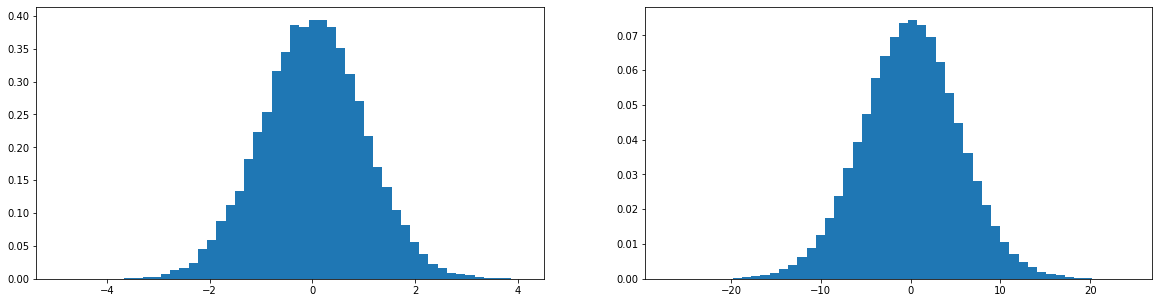

In [16]:
x = torch.randn(1000,30)
w = torch.randn(30,200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

## Diagnosis:

- Ideally, gaussian numbers have mean=0, std=1
- Say, out input **x** has gaussian distribution (0,1)
    - Also the weights initialized come from Gaussian (0,1)


#### Now, we want to analyze the changes that occur after matrix multiplication is done x @ w
- From prints above, it's evident that y's Gaussian has expanded
    - In sense, the **std** has shot up to ~3

### Whereas, we would want UNIT GAUSSIAN throughout the network
- How do we scale the W to maintain unit Gaussian

tensor(-0.0024) tensor(1.0013)
tensor(-0.0067) tensor(27.3415)


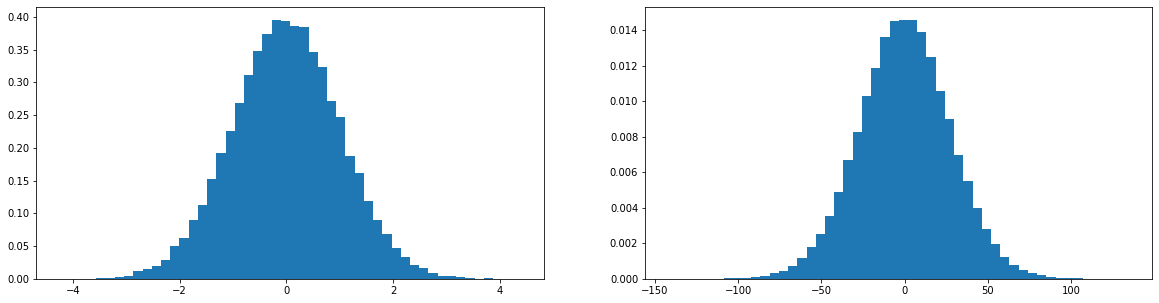

In [17]:
x = torch.randn(1000,30)
w = torch.randn(30,200) * 5 # This expands the Gaussian of y further.
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

tensor(0.0059) tensor(1.0025)
tensor(-0.0003) tensor(1.0957)


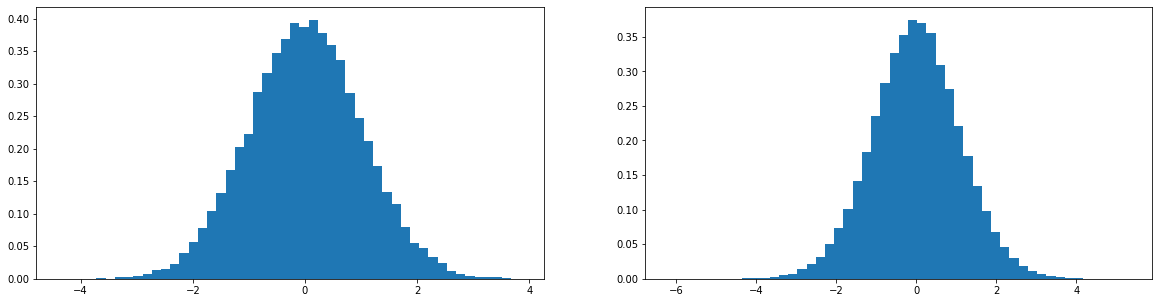

In [18]:
x = torch.randn(1000,30)
w = torch.randn(30,200) * 0.2 # This shrinks the Gaussian of y even below UNIT std.
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

---

## How to find the correct multiplier to maintain UNIT Gaussian?

- The correct answer comes from paper (https://arxiv.org/pdf/1502.01852.pdf)
## Divide by **```sqrt(fan_in)```**

    - ```fan_in```: number of input elements

tensor(0.0014) tensor(1.0025)
tensor(0.0012) tensor(0.9985)


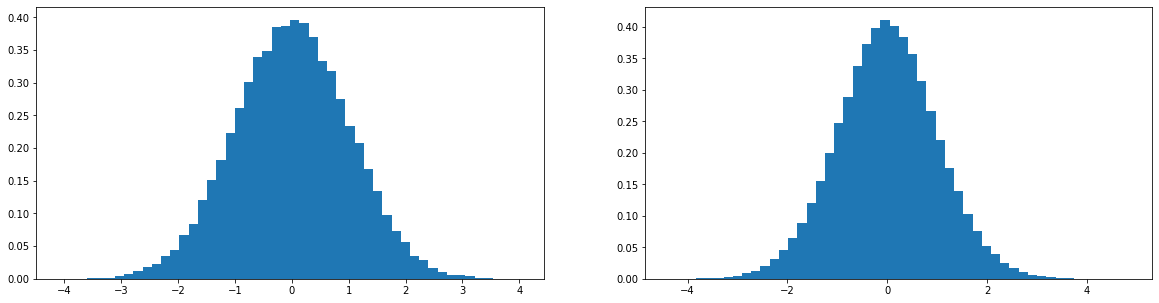

In [19]:
x = torch.randn(1000,30)
w = torch.randn(30,200) / 30**0.5 # This shrinks the Gaussian of y even below UNIT std.
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

## Important point:

- We want the activations throughout networks to be **well behaved**
- They shouldn't explode to very big number
    - Nor should got to 0

## From 'Kaiming He' paper, the scaling factor should be

- (5/3) / sqrt(fan_in) for **tanh**

In [20]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(0.0001) tensor(1.0006)
tensor(0.0004) tensor(0.6020)


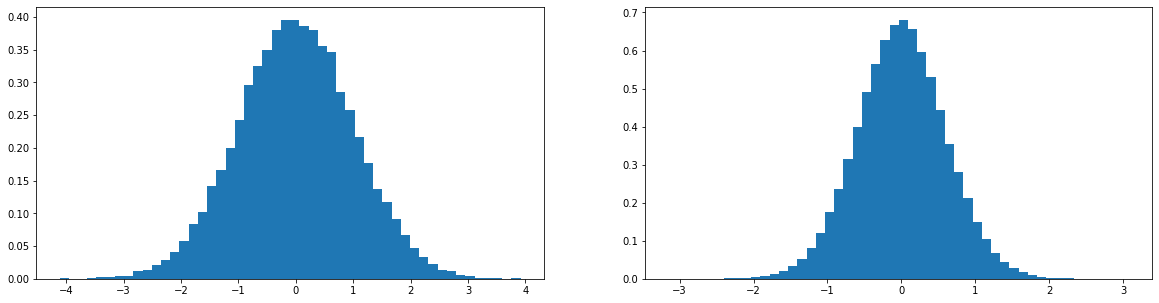

In [22]:
x = torch.randn(1000,30)
w = torch.randn(30,200) * (5/3)/ 30**0.5 # This shrinks the Gaussian of y even below UNIT std.
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [23]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ 30**0.5 #0.15
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [24]:
lri = []
lossi = []

In [25]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3032
  10000/ 200000: 2.0484
  20000/ 200000: 2.8247
  30000/ 200000: 2.2985
  40000/ 200000: 2.1025
  50000/ 200000: 2.4764
  60000/ 200000: 2.6015
  70000/ 200000: 2.3140
  80000/ 200000: 1.9098
  90000/ 200000: 2.0857
 100000/ 200000: 1.7765
 110000/ 200000: 1.9925
 120000/ 200000: 1.9428
 130000/ 200000: 2.2242
 140000/ 200000: 2.1578
 150000/ 200000: 2.0473
 160000/ 200000: 2.4547
 170000/ 200000: 2.1142
 180000/ 200000: 1.6728
 190000/ 200000: 1.8863


# In current scenario - initialization is not so serious step, due to other modern innvations

    - Normalizations, (batch-norm, layer-norm)
    - Residual connections
    
We move along to **batch-norm**